<H1> Cleaning du dataframe</H1>

* Dataframe sans noms de colonnes
* Colonne 3 une seule valeur --> suppression
* Les classes sont équilibrées
* Certains tweets et ce qui semble être la colonne id du tweet semblent êtres dupliqués
    * Certains tweets_id sont bien dupliqués et ont les deux étiquettes --> Supression de ces tweets et de la colonne tweet_id
    * D'autres tweets sont dupliqués et n'ont pas le même label --> Suppression de ces tweets
    * D'autres tweets sont dupliqués et ont le même label --> Conservation des tweets
* Changement des labels en 0 et 1
* Transformation de la colonne date en datetime

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import os

# Afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 20)

# Vérification des données

#### Vérifications basiques

In [2]:
df_import = pd.read_csv('documents/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)
df_import

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


<Axes: >

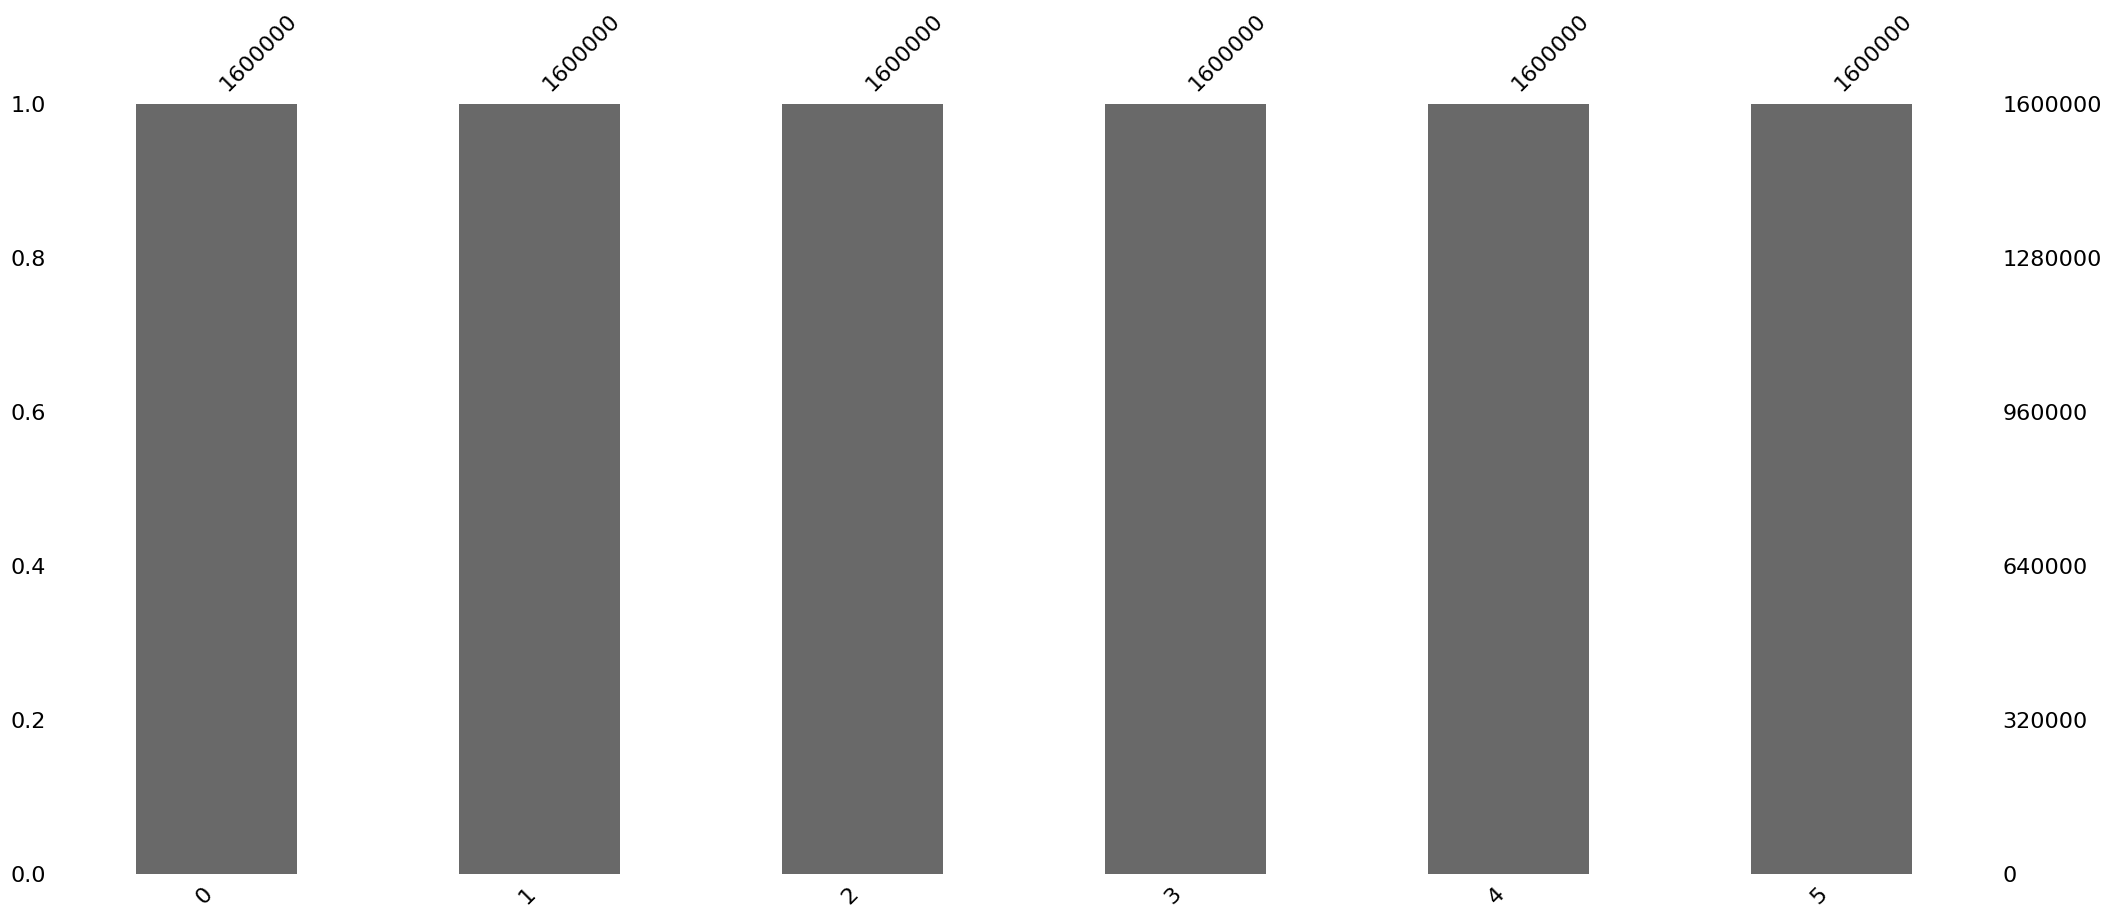

In [3]:
msno.bar(df_import)

In [4]:
# Voir le nombre de valeurs par variable

print(f'df shape : {df_import.shape}')
df_import.nunique()

df shape : (1600000, 6)


0          2
1    1598315
2     774363
3          1
4     659775
5    1581466
dtype: int64

In [5]:
# Voir si les classes sont équilibrées
df_import[0].value_counts()

0
0    800000
4    800000
Name: count, dtype: int64

In [6]:
# Retirer la colonne 3 qui n'a qu'une valeur
df_import = df_import.drop(3, axis=1)

In [7]:
# Donner un nom aux colonnes
df_import = df_import.rename(columns={0: 'label', 1: 'tweet_id', 2: 'date', 4: 'author', 5: 'tweet'})

In [8]:
# Transformation des labels
df_import['label'] = df_import['label'].replace(4, 1)

In [9]:
# Transformation des dates en datetime
df_import['date'] = pd.to_datetime(df_import['date'], format='%a %b %d %H:%M:%S PDT %Y')

In [10]:
# Voir s'il y a des lignes dupliquées
df_import.duplicated().any()

False

#### Valeurs dupliquées tweet_id

In [11]:
# Analyser les valeurs dupliquées de la colonne tweet_id
df_import_duplicated = df_import[df_import['tweet_id'].duplicated(keep=False)].sort_values('tweet_id')
print(f'df_import_duplicated shape : {df_import_duplicated.shape}')
df_import_duplicated.nunique()

df_import_duplicated shape : (3370, 5)


label          2
tweet_id    1685
date        1676
author      1601
tweet       1678
dtype: int64

In [12]:
#  verifier que chaque valeur unique de la colonne tweet_id est bien répété deux fois et a 0 et 4 en valeur de la colonne label
check_double_label = df_import_duplicated.groupby('tweet_id')['label'].nunique()
(check_double_label == 2).all()

True

In [13]:
# Récupérer les indices des tweets à double étiquette
duplicated_indices = df_import_duplicated.index

# Supprimer ces lignes du df
df_import = df_import.drop(duplicated_indices)

In [14]:
# Suppression de la colonne qui n'a plus qu'une valeur par tweet
df_import = df_import.drop('tweet_id', axis=1)

#### Valeurs dupliquées tweet

In [15]:
# Vérifier si les tweets dupliqués ont toujours le même label
df_tweet_duplicated = df_import[df_import['tweet'].duplicated(keep=False)].sort_values('tweet')
grouped_tweet = df_tweet_duplicated.groupby('tweet')['label'].nunique()
(grouped_tweet == 1).all()

False

In [16]:
# Analyser les tweets identiques qui n'ont pas le même label
tweets_with_multiple_labels = grouped_tweet[grouped_tweet > 1].index
df_tweet_duplicated_different_label = df_tweet_duplicated[df_tweet_duplicated['tweet'].isin(tweets_with_multiple_labels)]
df_tweet_duplicated_different_label

,label,date,author,tweet
507399,0,2009-06-15 22:46:53,Aryy1,I love you
1272390,1,2009-06-01 22:42:09,thatLenakid,I love you
1030537,1,2009-05-26 22:35:11,bradbury731,That is all.
730048,0,2009-06-21 00:52:30,Jessica_Tucker,That is all.
1268996,1,2009-06-01 21:29:16,Richard_0,goodnight
...,...,...,...,...
1299468,1,2009-06-02 10:43:33,elainer614,working from home
645646,0,2009-06-19 03:26:33,ashokvarda,working from home
633849,0,2009-06-18 20:53:18,hashbrown311,working out
1264530,1,2009-06-01 19:54:49,lauriegold11,working out


In [17]:
# Récupérer les indices des tweets à double étiquette
duplicated_indices_2 = df_tweet_duplicated_different_label.index

# Supprimer ces lignes du df
df_import = df_import.drop(duplicated_indices_2)

#### Voir les valeurs dupliquées de date

In [18]:
df_import.shape

(1593130, 4)

In [19]:
# Regarder les tweets qui sont identiques ont la même date et le même auteur
df_date_tweet_duplicated = df_import[df_import.duplicated(subset=['date', 'tweet', 'author'], keep=False)].sort_values('date')
df_date_tweet_duplicated

,label,date,author,tweet
812809,1,2009-04-17 21:27:11,quietyourcackle,productive friday night i found an old song t...
812810,1,2009-04-17 21:27:11,quietyourcackle,productive friday night i found an old song t...
9129,0,2009-04-17 21:27:22,YaaaaZ,Why am I awake @ 8am on a Sat morning?? Whyyyy...
9130,0,2009-04-17 21:27:22,YaaaaZ,Why am I awake @ 8am on a Sat morning?? Whyyyy...
9561,0,2009-04-17 22:00:01,tweetpet,@tweetchild Clean Me!
...,...,...,...,...
770438,0,2009-06-23 16:11:03,Susanluann,I effin locked my keys in my house and I'm stu...
791656,0,2009-06-25 06:26:14,AlexandraG730,@Ashley_Cashen Yes! I have to see you before y...
791655,0,2009-06-25 06:26:14,AlexandraG730,@Ashley_Cashen Yes! I have to see you before y...
792528,0,2009-06-25 06:51:59,noTHINGfaced,Records retention policies are a PITA. 21 CFR ...


In [20]:
df_import = df_import.drop_duplicates(subset=['date', 'tweet', 'author'], keep='first').sort_values('date')

In [21]:
df_import.shape

(1592943, 4)

#### Enregistrement du dataframe

In [22]:
df = df_import.copy().reset_index(drop=True)
df.to_csv('data/tweets_clean.csv', index=False)

# Tokenization des tweets

In [23]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

In [24]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jul/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Fonctions de transformation et tokennization

In [25]:
def tokenizer_with_hash_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

def tokenizer_no_hash_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

def stem_fct(list_words):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(w) for w in list_words]
    return stemmed_words

In [26]:
# No hashtags
# ---------------------------------------------------------

# Fonction de préparation du texte pour le bag of words
def transform_bow_no_hash_fct(desc_text) :
    word_tokens = tokenizer_no_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_no_hash_lem_fct(desc_text) :
    word_tokens = tokenizer_no_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


# Fonction de préparation du texte pour le bag of words avec stemming
def transform_bow_with_hash_stem_fct(desc_text) :
    word_tokens = tokenizer_no_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text





# With hashtags
# ---------------------------------------------------------

# Fonction de préparation du texte pour le bag of words avec hashtags
def transform_bow_with_hash_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization et hashtags
def transform_bow_with_hash_lem_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    stem_w = stem_fct(lw)    
    transf_desc_text = ' '.join(stem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec stemming et hashtags
def transform_bow_with_hash_stem_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

In [27]:
# No hashtags
# ---------------------------------------------------------


# Fonction de préparation du texte pour le Deep learning (USE et BERT) withour hashtage
def transform_dl_no_hash_fct(desc_text) :
    word_tokens = tokenizer_no_hash_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT) withour hashtage
def transform_dl_no_hash_lem_fct(desc_text) :
    word_tokens = tokenizer_no_hash_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

def transform_dl_with_hash_stem_fct(desc_text) :
    word_tokens = tokenizer_no_hash_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    stem_w = stem_fct(lw)    
    transf_desc_text = ' '.join(stem_w)
    return transf_desc_text




# With hashtags
# ---------------------------------------------------------

# Fonction de préparation du texte pour le Deep learning (USE et BERT) with hashtag
def transform_dl_with_hash_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

def transform_dl_with_hash_lem_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

def transform_dl_with_hash_stem_fct(desc_text) :
    word_tokens = tokenizer_with_hash_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    stem_w = stem_fct(lw)    
    transf_desc_text = ' '.join(stem_w)
    return transf_desc_text


#### Transformation des tweets

In [28]:
df['hash'] = df['tweet'].apply(lambda x : transform_bow_with_hash_fct(x))
df['hash_lem'] = df['tweet'].apply(lambda x : transform_bow_with_hash_lem_fct(x))
df['hash_stem'] = df['tweet'].apply(lambda x : transform_bow_with_hash_stem_fct(x))

df['no_hash'] = df['tweet'].apply(lambda x : transform_bow_no_hash_fct(x))
df['no_hash_lem'] = df['tweet'].apply(lambda x : transform_bow_no_hash_lem_fct(x))
df['no_hash_stem'] = df['tweet'].apply(lambda x : transform_bow_no_hash_fct(x))

df['dl'] = df['tweet'].apply(lambda x : transform_dl_with_hash_fct(x))
df['dl_lem'] = df['tweet'].apply(lambda x : transform_dl_with_hash_lem_fct(x))
df['dl_stem'] = df['tweet'].apply(lambda x : transform_dl_with_hash_stem_fct(x))

df['dl_no_hash'] = df['tweet'].apply(lambda x : transform_dl_no_hash_fct(x))
df['dl_no_hash_lem'] = df['tweet'].apply(lambda x : transform_dl_no_hash_lem_fct(x))
df['dl_no_hash_stem'] = df['tweet'].apply(lambda x : transform_dl_no_hash_fct(x))

In [29]:
# Retirer les lignes qui contiennent des nan après transformation
col = ['hash', 'hash_lem', 'hash_stem', 'no_hash', 'no_hash_lem', 'no_hash_stem', 'dl', 'dl_lem', 'dl_stem', 'dl_no_hash', 'dl_no_hash_lem', 'dl_no_hash_stem']
for c in col :
    df = df[df[c].isnull() == False]
    df = df[df[c] != '']
    df = df.reset_index(drop=True)

In [30]:
df.to_csv('data/tweets_tokenized.csv')

In [31]:
#df = pd.read_csv('data/tweets_tokenized.csv')

In [32]:
_, df_sample = train_test_split(df, test_size=0.01, stratify=df['label'], random_state=42)
df_sample.to_csv('data/tweets_tokenized_test_1.csv')

_, df_sample = train_test_split(df, test_size=0.05, stratify=df['label'], random_state=42)
df_sample.to_csv('data/tweets_tokenized_test_5.csv')

_, df_sample = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
df_sample.to_csv('data/tweets_tokenized_test_10.csv')

_, df_sample = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)
df_sample.to_csv('data/tweets_tokenized_test_25.csv')